In [1]:
from tqdm import tqdm
import os , sys

In [2]:
# for local imports, comment in colab if required
root = os.getcwd()
sys.path.append(root[: root.rindex('src')+4]+'scripts/')

In [3]:
import model as lenet_utils
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import struct
import time

## Dataset

In [4]:
# read the images and labels
def readDataset(dataset):
    (image, label) = dataset
    with open(label, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    return (img, lbl)

In [5]:
# the path of the dataset
test_image_path = r'../../MNIST/t10k-images-idx3-ubyte'
test_label_path = r'../../MNIST/t10k-labels-idx1-ubyte'
train_image_path = r'../../MNIST/train-images-idx3-ubyte'
train_label_path = r'../../MNIST/train-labels-idx1-ubyte'
training_set = (train_image_path, train_label_path)
test_set = (test_image_path, test_label_path)

In [6]:
# read the dataset with readDataset()
(train_images, train_labels) = readDataset(training_set)
(test_images, test_labels) = readDataset(test_set)
n_m, n_m_test = len(train_labels), len(test_labels)
print("The shape of training images dataset:", train_images.shape)
print("The shape of testing images dataset: ", test_images.shape)
print("Length of the training set: ", n_m)
print("Length of the test set: ", n_m_test)
print("Shape of a single image: ", train_images[0].shape)

The shape of training images dataset: (60000, 28, 28)
The shape of testing images dataset:  (10000, 28, 28)
Length of the training set:  60000
Length of the test set:  10000
Shape of a single image:  (28, 28)


### Normalization

In [7]:
# normalization of the input images
def normalize(image):
    image -= image.min()
    image = image / image.max()
    # range = [-0.1,1.175]   
    image = image * 1.275 - 0.1
    return image

In [8]:
X = normalize(lenet_utils.zero_pad(train_images[:,:,:,np.newaxis], 2))
X_test  = normalize(lenet_utils.zero_pad(test_images[:,:,:,np.newaxis],  2))
y = train_labels
y_test = test_labels
print("The shape of training image with padding:", X.shape)
print("The shape of testing image with padding: ", X_test.shape)
print("num of train labels", y.shape)
print("num of test labels", y_test.shape)

The shape of training image with padding: (60000, 32, 32, 1)
The shape of testing image with padding:  (10000, 32, 32, 1)
num of train labels (60000,)
num of test labels (10000,)


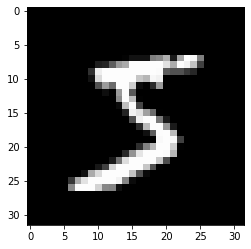

In [9]:
plt.imshow(X[0,:,:,0], cmap = 'gray')

### Train-Val Split

In [19]:
def train_test_split(X, y, ratio = 0.1):
    indices = list(np.random.choice(X.shape[0] , int(X.shape[0] * ratio), replace=False))
    left_over = list(set(range(X.shape[0])) - set(indices))
    return X[left_over, :, :, :], X[indices, : , :, :], y[left_over], y[indices]
    pass

In [20]:
x_train, x_val, y_train, y_val = train_test_split(X, y, 0.1)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(54000, 32, 32, 1) (6000, 32, 32, 1) (54000,) (6000,)


## Lenet

---

In [21]:
np.random.seed(10)
model = lenet_utils.Lenet_SMAI()
model.summary()
model.compile_adam()

		-------Lenet-------		
+--------------+-----------------------------------------+--------------+----------------+
| in           | Name (weight, bias)                     | out          |   total_params |
|--------------+-----------------------------------------+--------------+----------------|
| (32, 32, 1)  | CONV2D((5, 5, 1, 6), (1, 1, 1, 6))      | (28, 28, 6)  |            156 |
| (28, 28, 6)  | Activation(relu)                        | (28, 28, 6)  |              0 |
| (28, 28, 6)  | SubSample((1, 1, 1, 6), (1, 1, 1, 6))   | (14, 14, 6)  |             12 |
| (14, 14, 6)  | CONV2D((5, 5, 6, 16), (1, 1, 1, 16))    | (10, 10, 16) |           2416 |
| (10, 10, 16) | Activation(relu)                        | (10, 10, 16) |              0 |
| (10, 10, 16) | SubSample((1, 1, 1, 16), (1, 1, 1, 16)) | (5, 5, 16)   |             32 |
| (5, 5, 16)   | CONV2D((5, 5, 16, 120), (1, 1, 1, 120)) | (1, 1, 120)  |          48120 |
| (1, 1, 120)  | Activation(relu)                        | (1, 1, 

In [22]:
# batch_size = 32
# itr = 500
# st = time.time()
# img, label = np.random.rand(batch_size, 32, 32, 1), np.random.randint(0, 10,(batch_size,))
# for i in range(itr):
#     loss = model(img, label)
#     print(loss)
#     grads = model.compute_gradients()
#     model.apply_gradients(grads)
# print(f"accuracy : {np.count_nonzero(model(img, mode='test') == label) / batch_size}")
# print(f'took {time.time() - st} for {itr} batch steps of size {batch_size}, 1 prediction')

### Visualization

In [23]:
from IPython import display as ipythondisplay
from matplotlib.pyplot import figure
import time
class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None, figsize = (8,6)):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale
    self.figsize = figsize

    self.tic = time.time()

  def plot(self, data, epoch):
    if time.time() - self.tic > self.sec:
      plt.cla()
      plt.plot(data[0])
      if len(epoch) > 0: plt.vlines(x = epoch, ymin = 0, ymax = max(data[0]))
      if len(data[1]) > 0:
          plt.plot(data[1])
          plt.legend(["train_loss", "val_loss"])
      else:
        plt.legend(["train_loss"])
      plt.ylabel(self.ylabel)
      plt.xlabel(self.xlabel)
      plt.tight_layout()
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [24]:
plotter = PeriodicPlotter(xlabel='iterations', ylabel='loss', sec = 2)

### Train

In [25]:
epochs = 20
batch_size = 512


In [26]:
def mean_val_loss(lenet_model, x_val, y_val):
    batch_size = 512
    return np.mean([lenet_model(x_val[i:i+batch_size, :, :, :], y_val[i:i+batch_size]) for i in range(0, x_val.shape[0], batch_size)])

In [27]:
def accuracy(lenet_model, x, y):
    batch_size = 512
    acc = []
    for i in tqdm(range(0, x.shape[0], batch_size)):
        pred = lenet_model(x[i:i+batch_size, :, :, :], None, 'test')
        acc.append(np.count_nonzero(y[i:i+batch_size] == pred) / pred.shape[0])
    return np.mean(acc)

In [28]:
history = [[],[]]

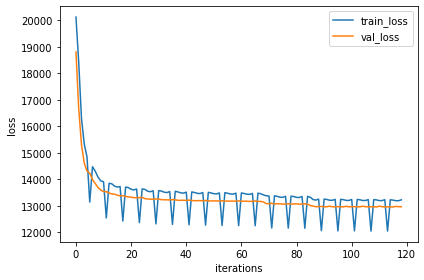

epoch = 20, train_loss = 13230.344680896753, val_loss = 12970.247682858337, val_acc = 0.9867881000905797: 100%|██████████| 106/106 [01:09<00:00,  1.52it/s]


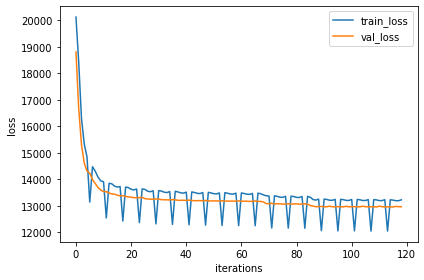

In [29]:
for e in range(epochs):
    loss = []
    k = 0
    t = tqdm(range(0, x_train.shape[0] ,batch_size))
    for i in t:
        input = x_train[i : i + batch_size , :, :, :]
        labels = y_train[i : i + batch_size]
        loss.append(model(input, labels))
        grads = model.compute_gradients()
        model.apply_gradients(grads)
        k+=1
        if k % 20 == 0:
            history[0].append(np.mean(loss))
            history[1].append(mean_val_loss(model, x_val, y_val))
            val_acc = accuracy(model, x_val, y_val)
            t.set_description(f'epoch = {e + 1}, train_loss = {history[0][-1]}, val_loss = {history[1][-1]}, val_acc = {val_acc}')
            loss = []
            plotter.plot(history, [])
    history[0].append(np.mean(loss)) 
    history[1].append(mean_val_loss(model, x_val, y_val))

In [30]:
accuracy(model, X_test, y_test)

100%|██████████| 20/20 [00:03<00:00,  6.30it/s]


0.9878619025735293

Save and Load model

In [31]:
import pickle as pk

In [32]:
def model_save(model):
    weights = []
    for layer in model.layers:
        print(layer)
        weights.append(layer.params)
    return weights

In [33]:
def load_weights(model, weights):
    for i,layer in enumerate(model.layers):
        print(layer) 
        layer.params = weights[i]

In [34]:
with open('model-relu-20-512-adam.pickle', 'wb') as f:
    pk.dump(model_save(model), f, pk.HIGHEST_PROTOCOL)

CONV2D((5, 5, 1, 6), (1, 1, 1, 6))
Activation(relu)
SubSample((1, 1, 1, 6), (1, 1, 1, 6))
CONV2D((5, 5, 6, 16), (1, 1, 1, 16))
Activation(relu)
SubSample((1, 1, 1, 16), (1, 1, 1, 16))
CONV2D((5, 5, 16, 120), (1, 1, 1, 120))
Activation(relu)
Dense((120, 84), (84,))
Activation(relu)
RBF(10, 84)


In [35]:
model_2 = lenet_utils.Lenet_SMAI()
with open('model-relu-20-512-adam.pickle', 'rb') as f:
    weights = pk.load(f)
    load_weights(model_2, weights)

CONV2D((5, 5, 1, 6), (1, 1, 1, 6))
Activation(relu)
SubSample((1, 1, 1, 6), (1, 1, 1, 6))
CONV2D((5, 5, 6, 16), (1, 1, 1, 16))
Activation(relu)
SubSample((1, 1, 1, 16), (1, 1, 1, 16))
CONV2D((5, 5, 16, 120), (1, 1, 1, 120))
Activation(relu)
Dense((120, 84), (84,))
Activation(relu)
RBF(10, 84)


In [36]:
accuracy(model_2, X_test, y_test)

100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


0.9878619025735293

In [44]:
model_2(X_test[:10], mode = 'test'), y_test[:10]

(array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int8))